## Image Classification in Shopee Code League 2020

Original source from [kaggle notebook](https://www.kaggle.com/code/indralin/train-uses-tpu-in-kaggle-kernel-baseline-0-82)

<div class="alert alert-success"> <b>Got score 0.82 using only single-model, not bad</b> </div>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [4]:
train_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/test.csv')

train_df.shape, test_df.shape

((105390, 2), (12186, 2))

In [5]:
train_df.head()

filename  category
0  45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg         3
1  f74d1a5fc2498bbbfa045c74e3cc333e.jpg         3
2  f6c172096818c5fab10ecae722840798.jpg         3
3  251ffd610399ac00fea7709c642676ee.jpg         3
4  73c7328b8eda399199fdedec6e4badaf.jpg         3

<font size="+2" color="chocolate"><b>Pick random sample, 2500 image for each categories</b></font><br><a id="1"></a>

* I think this is not the right way, because a lot of noisy images for each category (with different resolution too)
* I suggest we do **webscraping** for add more training images, and **removing irrelevant ones**
* For do that, we need a teamwork + time (a lot)

In [6]:
def show_train_img(category):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    train_path = '/kaggle/input/shopee-product-detection-open/train/train/train/'
    ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(train_path, category, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

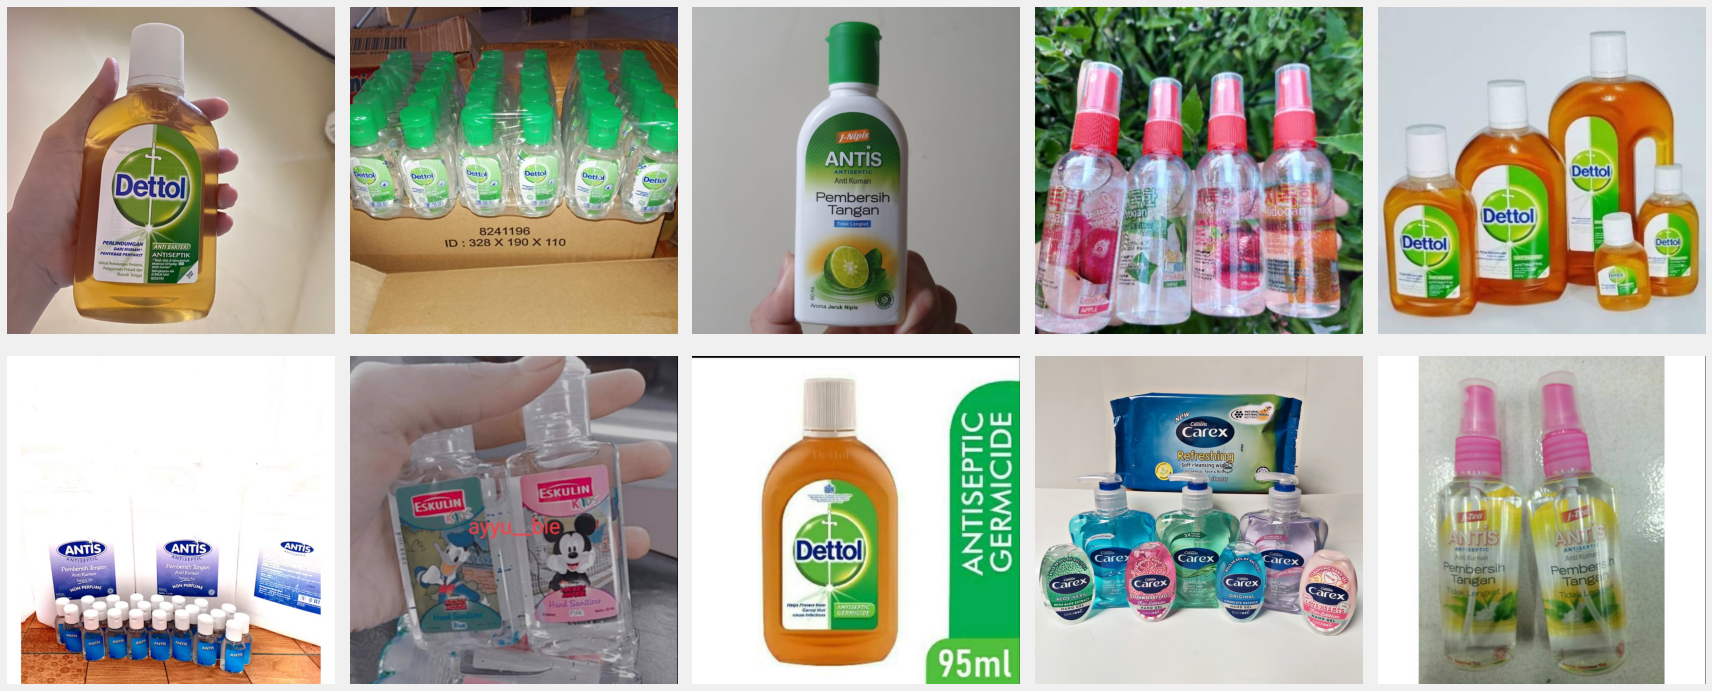

In [7]:
# category 33 only has 573 images == class imbalanced
# category 11, 37, 17 also has less than 2000 images

show_train_img('33')

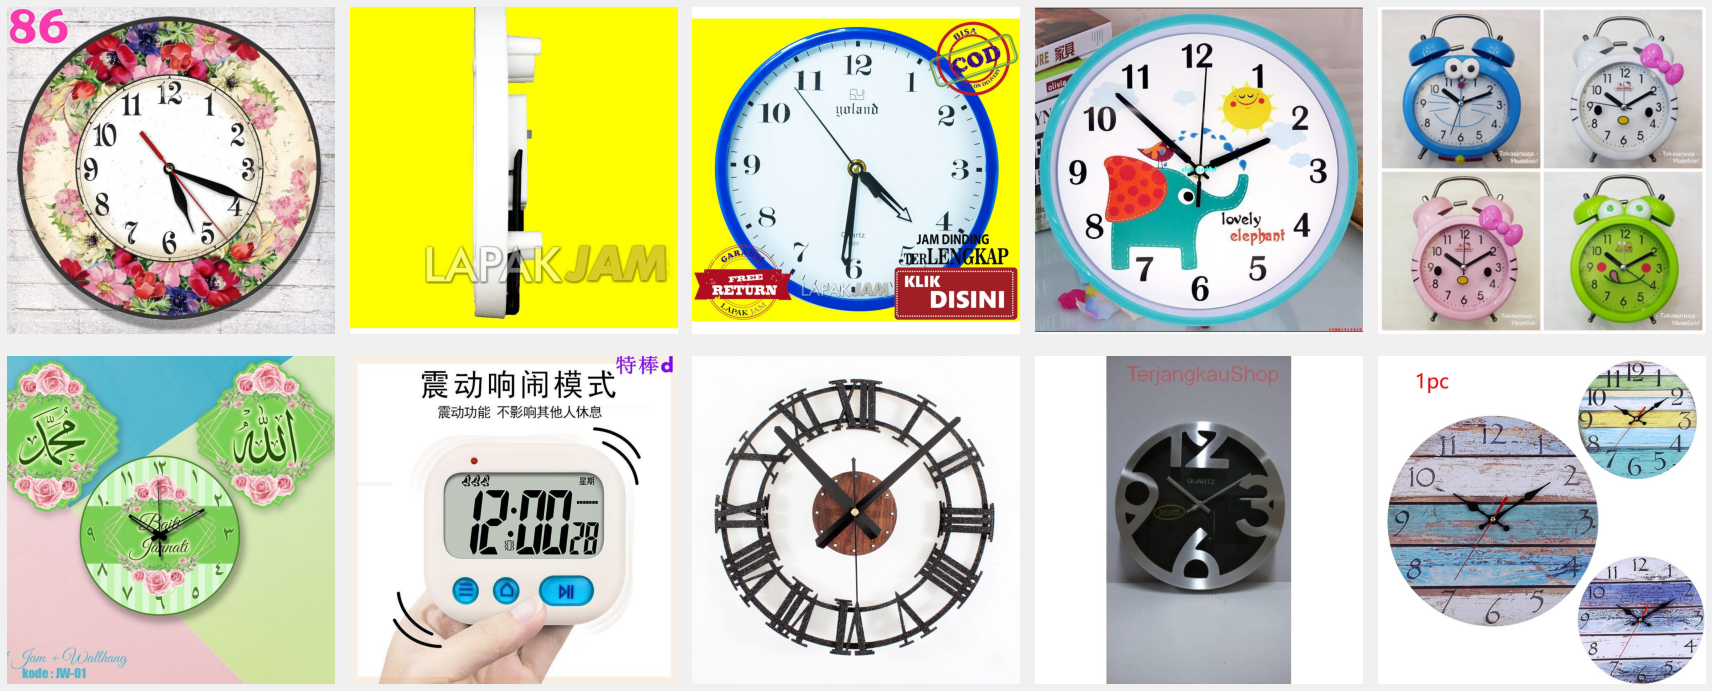

In [8]:
show_train_img('12')

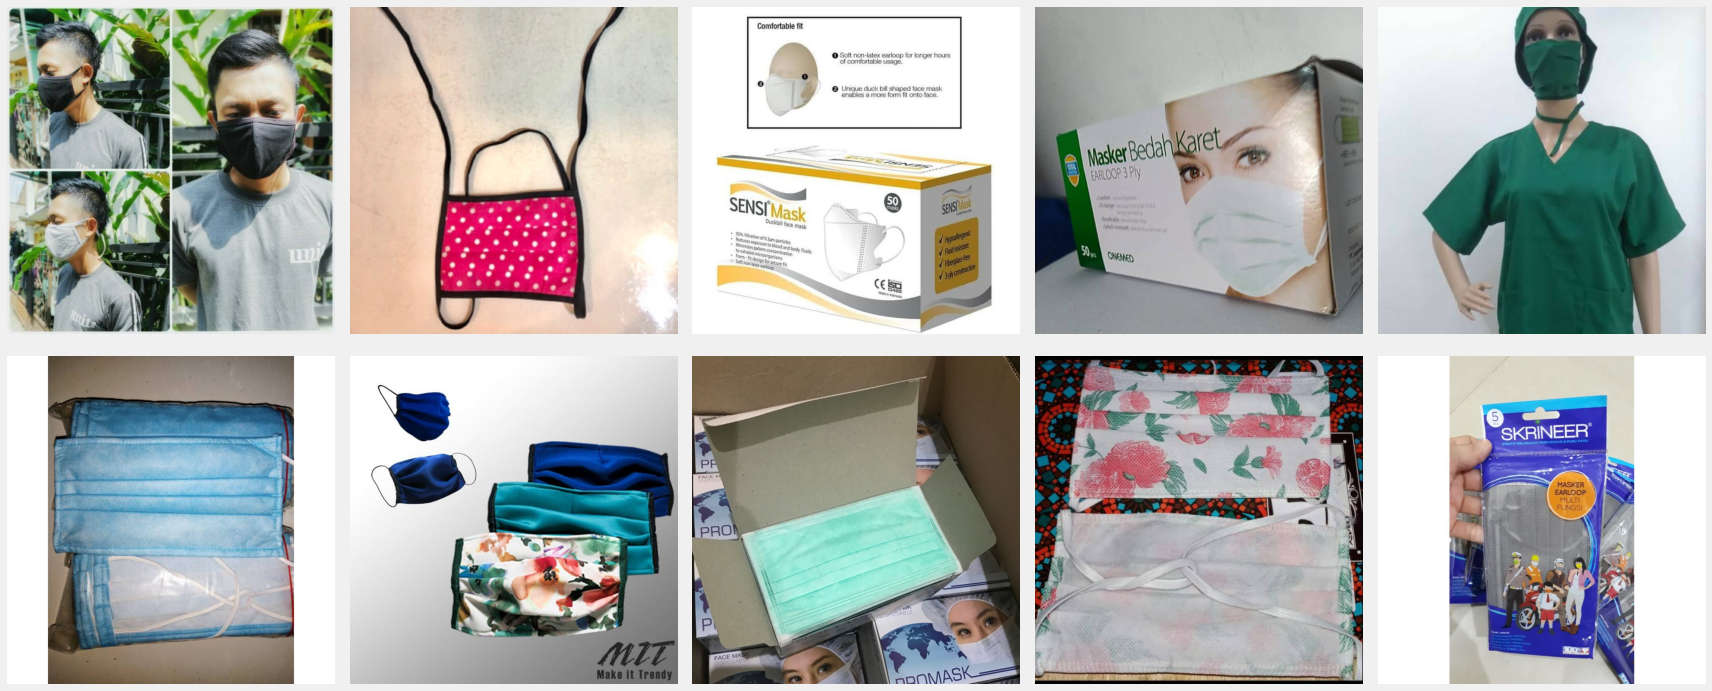

In [9]:
show_train_img('32')

<font size="+2" color="purple"><b>Show images in test dataset</b></font><br><a id="1"></a>

In [10]:
def show_test_img():
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    test_path = '/kaggle/input/shopee-product-detection-open/test/test/test/'
    ten_random_samples = pd.Series(os.listdir(test_path)).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(test_path, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

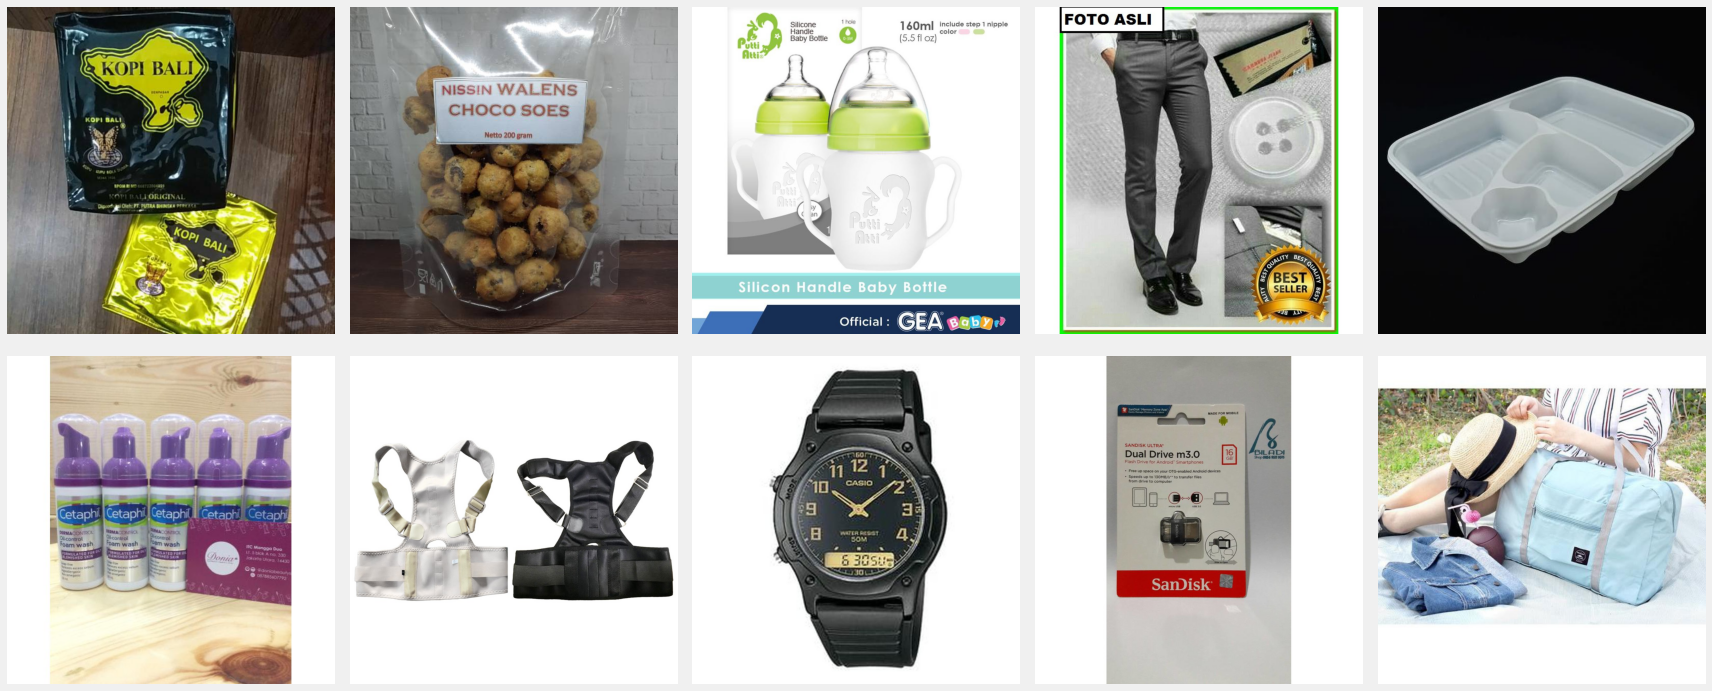

In [11]:
show_test_img()

In [12]:
# pick random samples

dataset_path = {}

categories = np.sort(train_df['category'].unique())

for cat in categories:
    try:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(2500)
    except:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1.)

In [13]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

In [14]:
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

In [15]:
labels = []

for label in dataset_path.keys():
    labels.extend([label] * len(dataset_path[label]))

In [16]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
train_labels = to_categorical(labels)

In [17]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        stratify=train_labels,
                                                                        test_size=0.1, 
                                                                        random_state=2020)

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((89632,), (9960,), (89632, 42), (9960, 42))

In [18]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))
    
test_paths = np.array(test_paths)

In [19]:
def decode_image(filename, label=None, image_size=(456, 456)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

## Data Augmentation

* Data augmentation is more of an art than a science. If you do it wrong, you hurt the accuracy.
* Some may believe that the more types of data augmentation we include, the better the model. This is not true and varies with context.

> You also can use gridmask / cutmix / mixup etc for experiment

In [20]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.25)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
#     image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
#     image = tf.image.random_hue(image, max_delta=0.2)
    
    if label is None:
        return image
    else:
        return image, label

In [21]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## Efficient-Net

In May 2019, Google published both a very exciting paper and source code for a newly designed CNN called EfficientNet, that set new records for both accuracy and computational efficiency. Here’s the results of EfficientNet, scaled to different block layers (B1, B2, etc) vs. most other popular CNN’s.

![Architecture](https://miro.medium.com/max/985/1*nQ5HYZ1xiIGn092Y5H5SIQ.jpeg)

As the image shows, EfficientNet tops the current state of the art both in accuracy and in computational efficiency. How did they do this?

### Model scaling

They learned that CNN’s must be scaled up in **depth, width, and input image resolution together** to improve the performance of the model. The scaling method is named **compound scaling** and suggests that instead of scaling only one model attribute out of depth, width, and resolution; strategically scaling all three of them together delivers better results.

There is a synergy in scaling depth, width and image-resolution together, and after an extensive grid search derived the theoretically optimal formula of “compound scaling” using the following co-efficients:

* Depth = 1.20
* Width = 1.10
* Resolution = 1.15

Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN.

In other words, to scale up the CNN, the depth of layers should increase 20%, the width 10% and the image resolution 15% to keep things as efficient as possible while expanding the implementation and improving the CNN accuracy. This compound scaling formula is used to scale up the EfficientNet from B0-B7

### Swish Activation

![swish-activation](https://miro.medium.com/max/1400/0*EhAHcCmGOzQUgQ0k)

ReLu works pretty well but it got a problem, it nullifies negative values and thus derivatives are zero for all negative values. There are many known alternatives to tackle this problem like leaky ReLu, Elu, Selu etc., but none of them has proven consistent.

Google Brain team suggested a newer activation that tends to work better for deeper networks than ReLU which is a Swish activation. They proved that if we replace Swish with ReLu on InceptionResNetV2, we can achieve 0.6% more accuracy on ImageNet dataset.

> Swish(x) = x * sigmoid(x)

There are other things like MBConv Block etc. If you want to know more details, you can read the articles in reference below

In [22]:
!pip install -q efficientnet

In [23]:
from tensorflow.keras.layers import Dense, Lambda, Input
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB5

## Use focal loss with label smoothing

When using deep learning models for classification tasks, we usually encounter the following problems: overfitting, and overconfidence. Overfitting is well studied and can be tackled with early stopping, dropout, weight regularization etc. On the other hand, we have less tools to tackle overconfidence. Label smoothing is a regularization technique that addresses both problems.

Label smoothing is used when the loss function is cross entropy, and the model applies the softmax function to the penultimate layer’s logit vectors z to compute its output probabilities p.

> Whenever a classification neural network suffers from overfitting and/or overconfidence, we can try label smoothing.

In [24]:
import keras.backend as K

def categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.25, ls=0.1, classes=42.0):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
        y_ls = (1 - α) * y_hot + α / classes
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
        ls    -- label smoothing parameter(alpha)
        classes     -- No. of classes
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
        ls    -- 0.1
        classes     -- 42
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        #label smoothing
        y_pred_ls = (1 - ls) * y_pred + ls / classes
        # Clip the prediction value
        y_pred_ls = K.clip(y_pred_ls, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred_ls)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred_ls), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

Using TensorFlow backend.


Original Model

In [25]:
# %%time

# with strategy.scope():
#     model = tf.keras.Sequential([
#         EfficientNetB5(weights='noisy-student', # imagenet
#                        include_top=False,
#                        pooling='avg'), # max
#         Dense(42, activation='softmax')
#     ])
    
#     model.layers[0].trainable = False
    
#     model.compile(optimizer = 'adam',
#                   loss = categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=42.0), # num classes
#                   metrics=['accuracy'])
    
#     model.summary()

## Bilinear Efficient-Net B5

![bilinear cnn](https://miro.medium.com/max/820/1*Y-629BmgDNFpLumnklJyaA.png)

I got inspiration from [this notebook](https://www.kaggle.com/jimitshah777/bilinear-efficientnet-focal-loss-label-smoothing/data), but make a little change to Efficient-Net B5

In [26]:
def outer_product(x):
    #Einstein Notation  [batch,1,1,depth] x [batch,1,1,depth] -> [batch,depth,depth]
    phi_I = tf.einsum('ijkm,ijkn->imn', x[0], x[1])
    
    # Reshape from [batch_size,depth,depth] to [batch_size, depth*depth]
    phi_I = tf.reshape(phi_I,[-1,x[0].shape[3]*x[1].shape[3]])
    
    # Divide by feature map size [sizexsize]
    size1 = int(x[1].shape[1])
    size2 = int(x[1].shape[2])
    phi_I = tf.divide(phi_I, size1*size2)
    
    # Take signed square root of phi_I
    y_ssqrt = tf.multiply(tf.sign(phi_I),tf.sqrt(tf.abs(phi_I)+1e-12))
    
    # Apply l2 normalization
    z_l2 = tf.nn.l2_normalize(y_ssqrt, axis=1)
    return z_l2

In [27]:
IMG_SIZE_h = 456 
IMG_SIZE_w = 456

def get_model():
    
    input_tensor = Input(shape=(IMG_SIZE_h, IMG_SIZE_w, 3))
    
    model1 = EfficientNetB5(weights='imagenet', include_top=False, input_tensor=input_tensor,input_shape=(IMG_SIZE_h, IMG_SIZE_w, 3))
    model2 = EfficientNetB5(weights='noisy-student', include_top=False, input_tensor=input_tensor,input_shape=(IMG_SIZE_h, IMG_SIZE_w, 3))    
    
    for layer in model1.layers:
        layer._name = 'model1_' + layer.name

    last_layer1 = model1.get_layer('model1_top_conv')
    last_output1 = last_layer1.output

    for layer in model2.layers:
        layer._name = 'model2_' + layer.name

    last_layer2 = model2.get_layer('model2_top_conv')
    last_output2 = last_layer2.output
    
    
    model1_ = Model(inputs=model1.input, outputs=last_output1)
    model2_ = Model(inputs=model2.input, outputs=last_output2)
    
    model1_.trainable = False
    model2_.trainable = False
    
    model1_.compile('adam', loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=42.0))
    model2_.compile('adam', loss=categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=42.0))
    
    d1 = model1_.output
    d2 = model2_.output

    bilinear = Lambda(outer_product, name='outer_product1')([d1,d2])
    
    predictions=Dense(42, activation='softmax', name='predictions')(bilinear)
    model = Model(inputs=model1.input, outputs=predictions)

    return model

In [28]:
with strategy.scope():
    
    model = get_model()

    model.compile(optimizer = 'adam',
                  loss = categorical_focal_loss_with_label_smoothing(gamma=2.0, alpha=0.75, ls=0.125, classes=42.0), # num classes
                  metrics=['categorical_accuracy'])

115261440/115255328 [==============================] - 4s 0us/step


In [29]:
import math

LR = 0.0005
EPOCHS = 16
WARMUP = 4

def get_cosine_schedule_with_warmup(lr, num_warmup_steps, num_training_steps, num_cycles=0.5):
    """
    Modified the get_cosine_schedule_with_warmup from huggingface for tensorflow
    (https://huggingface.co/transformers/_modules/transformers/optimization.html#get_cosine_schedule_with_warmup)

    Create a schedule with a learning rate that decreases following the
    values of the cosine function between 0 and `pi * cycles` after a warmup
    period during which it increases linearly between 0 and 1.
    """

    def lrfn(epoch):
        if epoch < num_warmup_steps:
            return float(epoch) / float(max(1, num_warmup_steps)) * lr
        progress = float(epoch - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

lr_schedule= get_cosine_schedule_with_warmup(lr=LR, num_warmup_steps=WARMUP, num_training_steps=EPOCHS)

In [30]:
n_steps = train_labels.shape[0] // BATCH_SIZE  # 89632 / 128 = 700

history = model.fit(
    train_dataset, 
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    callbacks=[lr_schedule]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0.
Epoch 1/16
700/700 [==============================] - 2652s 4s/step - loss: 2.6714 - categorical_accuracy: 0.0220 - val_loss: 2.6714 - val_categorical_accuracy: 0.0223 - lr: 0.0000e+00

Epoch 00002: LearningRateScheduler reducing learning rate to 0.000125.
Epoch 2/16
700/700 [==============================] - 208s 297ms/step - loss: 1.1314 - categorical_accuracy: 0.6523 - val_loss: 0.5694 - val_categorical_accuracy: 0.7481 - lr: 1.2500e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00025.
Epoch 3/16
700/700 [==============================] - 208s 297ms/step - loss: 0.6231 - categorical_accuracy: 0.7384 - val_loss: 0.4713 - val_categorical_accuracy: 0.7802 - lr: 2.5000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000375.
Epoch 4/16
700/700 [==============================] - 208s 297ms/step - loss: 0.5143 - categorical_accuracy: 0.7655 - val_loss: 0.4342 - val_categorical_accura

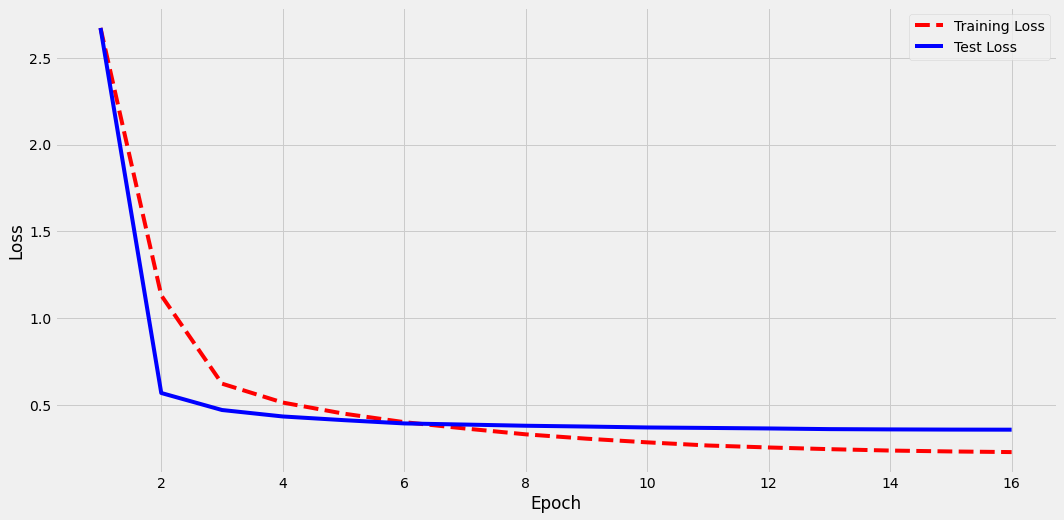

In [31]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [32]:
# pred = model.predict(test_dataset, verbose=1)

In [33]:
# # drop existing feature
# test_df = test_df.drop('category', axis=1)

# # change with prediction
# test_df['category'] = pred.argmax(axis=1)

# # then add zero-padding
# test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [34]:
# test_df.to_csv('submission.csv', index=False)

## Make a submission with TTA

![tta](https://preview.ibb.co/kH61v0/pipeline.png)
source: [Test Time Augmentation (TTA) ... worth it?](https://www.kaggle.com/andrewkh/test-time-augmentation-tta-worth-it)

* TTA is simply to apply different transformations to test image like: rotations, flipping and translations.
* Then feed these different transformed images to the trained model and **average the results** to get more confident answer.

In [35]:
test_dataset_tta = (
        tf.data.Dataset
        .from_tensor_slices(test_paths)
        .map(decode_image, num_parallel_calls=AUTO)
        .cache()
        .map(data_augment, num_parallel_calls=AUTO)
        .batch(BATCH_SIZE)
)

tta_times = 5
probabilities = []

for i in range(tta_times+1):
    print('TTA Number: ', i, '\n')
    probabilities.append(model.predict(test_dataset_tta, verbose=1))
    
tta_pred = np.mean(probabilities, axis=0)

TTA Number:  0 

96/96 [==============================] - 330s 3s/step
TTA Number:  1 

96/96 [==============================] - 32s 332ms/step
TTA Number:  2 

96/96 [==============================] - 31s 327ms/step
TTA Number:  3 

96/96 [==============================] - 31s 328ms/step
TTA Number:  4 

96/96 [==============================] - 32s 329ms/step
TTA Number:  5 

96/96 [==============================] - 31s 326ms/step


In [36]:
# change with prediction
test_df['category'] = tta_pred.argmax(axis=1)

# then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [37]:
test_df.to_csv('sub_with_tta_transform.csv', index=False)

# Reference:

[EfficientNet from Google — Optimally Scaling CNN model architectures with “compound scaling”](https://medium.com/@lessw/efficientnet-from-google-optimally-scaling-cnn-model-architectures-with-compound-scaling-e094d84d19d4)

[Image Classification with EfficientNet: Better performance with computational efficiency](https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6)

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95)

[What is Label Smoothing?](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06)

[Bilinear CNNs for Fine-grained Visual Recognition](https://arxiv.org/pdf/1812.01187.pdf)

In [38]:
# !git clone https://github.com/bckenstler/CLR.git

In [39]:
# from CLR.clr_callback import CyclicLR

# clr = CyclicLR(base_lr = 0.003,
#               max_lr = 0.1,
#               step_size = (4 * (train_labels.shape[0] // BATCH_SIZE)),
#               mode = 'triangular')

# model.fit(X_train, Y_train, callbacks=[clr])